## Victor Gómez
### victor.gomez@cimat.mx


# Maestría en Cómputo Estadístico
# CIMAT Monterrey

# <center>Tópicos selectos de Cómputo<center>
# <center>Proyecto Final: Clases desbalanceadas y selección de características<center>

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
#ubicacion de la carpeta actual
CurrentPath = '/content/drive/My Drive/Colab Notebooks/PROYECTO/DatosModelosCodigo/'

In [ ]:
# librerias
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
from sklearn.metrics import roc_curve, roc_auc_score, balanced_accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.preprocessing import StandardScaler
from imblearn.pipeline  import Pipeline
from sklearn.metrics import accuracy_score
from datetime import datetime
import xgboost as xgb
from sklearn.ensemble import AdaBoostClassifier
from sklearn.model_selection import GridSearchCV,RandomizedSearchCV,cross_val_score
import imblearn as imb
from imblearn import over_sampling as os
from imblearn import under_sampling as us
from imblearn import ensemble as ens
from imblearn import combine as co
from sklearn.inspection import permutation_importance
import joblib

/usr/local/lib/python3.6/dist-packages/sklearn/externals/six.py:31: FutureWarning:

The module is deprecated in version 0.21 and will be removed in version 0.23 since we've dropped support for Python 2.7. Please rely on the official version of six (https://pypi.org/project/six/).

/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:144: FutureWarning:

The sklearn.neighbors.base module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.neighbors. Anything that cannot be imported from sklearn.neighbors is now part of the private API.

/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:144: FutureWarning:

The sklearn.ensemble.bagging module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.ensemble. Anything that cannot be imported from sklearn.ensemble is now part o

# Datos para Clasificación binaria Desbalanceada:

- https://archive.ics.uci.edu/ml/datasets/Bank+Marketing

In [ ]:
#leer y revisar los datos
df=pd.read_csv(CurrentPath+'bank-full.csv',sep=';')
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 45211 entries, 0 to 45210
Data columns (total 17 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   age        45211 non-null  int64 
 1   job        45211 non-null  object
 2   marital    45211 non-null  object
 3   education  45211 non-null  object
 4   default    45211 non-null  object
 5   balance    45211 non-null  int64 
 6   housing    45211 non-null  object
 7   loan       45211 non-null  object
 8   contact    45211 non-null  object
 9   day        45211 non-null  int64 
 10  month      45211 non-null  object
 11  duration   45211 non-null  int64 
 12  campaign   45211 non-null  int64 
 13  pdays      45211 non-null  int64 
 14  previous   45211 non-null  int64 
 15  poutcome   45211 non-null  object
 16  y          45211 non-null  object
dtypes: int64(7), object(10)
memory usage: 5.9+ MB


In [ ]:
df.head()

,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome,y
0,58,management,married,tertiary,no,2143,yes,no,unknown,5,may,261,1,-1,0,unknown,no
1,44,technician,single,secondary,no,29,yes,no,unknown,5,may,151,1,-1,0,unknown,no
2,33,entrepreneur,married,secondary,no,2,yes,yes,unknown,5,may,76,1,-1,0,unknown,no
3,47,blue-collar,married,unknown,no,1506,yes,no,unknown,5,may,92,1,-1,0,unknown,no
4,33,unknown,single,unknown,no,1,no,no,unknown,5,may,198,1,-1,0,unknown,no


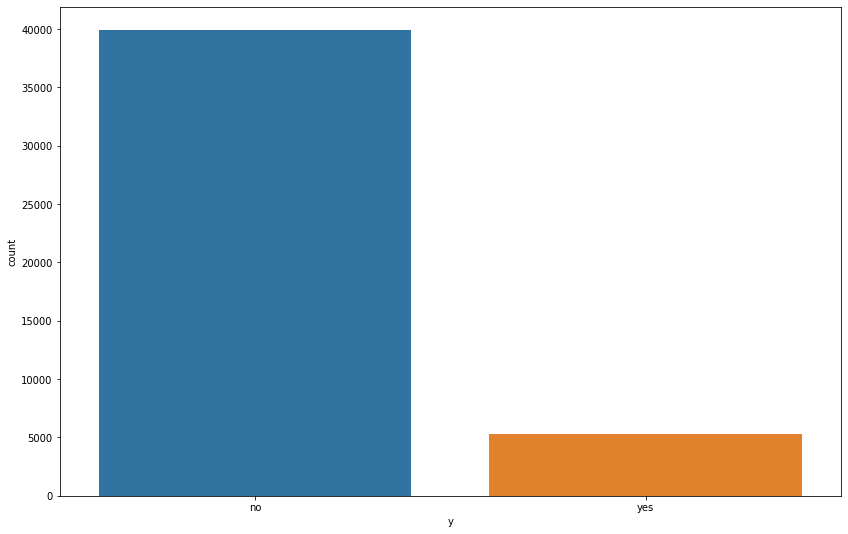

In [ ]:
f, ax = plt.subplots(figsize=(14,9)) #clases
sns.countplot(x="y", data=df)

In [ ]:
df.y.value_counts()/len(df) #% de cada clase

no     0.883015
yes    0.116985
Name: y, dtype: float64

# Imbalance Ratio:

In [ ]:
IR=df.y.value_counts()[0]/df.y.value_counts()[1]
IR #Imbalance Ratio

7.548118737001324

In [ ]:
#variables dummies y se quita 1 variable de cada categoria
df2=pd.get_dummies(df)
df2=df2.drop(columns=['y_no','job_unknown','marital_divorced','education_unknown','default_no','housing_no','loan_no','contact_unknown','poutcome_unknown'])
df2.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 45211 entries, 0 to 45210
Data columns (total 44 columns):
 #   Column               Non-Null Count  Dtype
---  ------               --------------  -----
 0   age                  45211 non-null  int64
 1   balance              45211 non-null  int64
 2   day                  45211 non-null  int64
 3   duration             45211 non-null  int64
 4   campaign             45211 non-null  int64
 5   pdays                45211 non-null  int64
 6   previous             45211 non-null  int64
 7   job_admin.           45211 non-null  uint8
 8   job_blue-collar      45211 non-null  uint8
 9   job_entrepreneur     45211 non-null  uint8
 10  job_housemaid        45211 non-null  uint8
 11  job_management       45211 non-null  uint8
 12  job_retired          45211 non-null  uint8
 13  job_self-employed    45211 non-null  uint8
 14  job_services         45211 non-null  uint8
 15  job_student          45211 non-null  uint8
 16  job_technician       4

In [ ]:
df2.head()

,age,balance,day,duration,campaign,pdays,previous,job_admin.,job_blue-collar,job_entrepreneur,job_housemaid,job_management,job_retired,job_self-employed,job_services,job_student,job_technician,job_unemployed,marital_married,marital_single,education_primary,education_secondary,education_tertiary,default_yes,housing_yes,loan_yes,contact_cellular,contact_telephone,month_apr,month_aug,month_dec,month_feb,month_jan,month_jul,month_jun,month_mar,month_may,month_nov,month_oct,month_sep,poutcome_failure,poutcome_other,poutcome_success,y_yes
0,58,2143,5,261,1,-1,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0
1,44,29,5,151,1,-1,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0
2,33,2,5,76,1,-1,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,1,0,0,1,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0
3,47,1506,5,92,1,-1,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0
4,33,1,5,198,1,-1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0


In [ ]:
# datos para el modelo
y=df2['y_yes'].values
X=df2.drop(columns=['y_yes']).values

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2) #conjunto de entrenamiento y prueba

## Ajuste mediante RandomizedSearchCV con validación cruzada 5-fold y metrica ROC-AUC

# Baseline:
- XGB

In [ ]:
#xgb
def XGBoost_model(num_classes=2):
    
    gbm_param_grid={'learning_rate':[1e-5,1e-4,1e-3,1e-2,1e-1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9], 
               'n_estimators':[50],
               'subsample':[0.5,0.6,0.7],
                'colsample_bytree':[0.8,0.9,1],
               'gamma':[0,1,10,100,1000],
               'lambda':[0,1,10,100,1000]
               }
    
    if num_classes ==2:
        gbm=xgb.XGBClassifier(seed=123)
                
    
    
    return gbm, gbm_param_grid 

classifier,params=XGBoost_model()
model = RandomizedSearchCV(classifier,param_distributions=params,scoring='roc_auc',cv=5,n_jobs=-1,random_state=0)
model.fit(X_train,y_train)

# Print the tuned parameters and score
print("Tuned XGB Parameters: {}".format(model.best_params_)) 
print("Best score is {}".format(model.best_score_))

Tuned XGB Parameters: {'subsample': 0.6, 'n_estimators': 50, 'learning_rate': 0.3, 'lambda': 1, 'gamma': 0, 'colsample_bytree': 0.9}
Best score is 0.9288175845633283


In [ ]:
#ajuste con early_stopping
model=xgb.XGBClassifier(seed=123, learning_rate=0.3,n_estimators=500,subsample=0.6,gamma=0,reg_lambda=1,colsample_bytree=0.9)
model.fit(X_train,y_train,eval_set=[(X_test,y_test)],eval_metric='auc',early_stopping_rounds=10)

[0]	validation_0-auc:0.762533
Will train until validation_0-auc hasn't improved in 10 rounds.
[1]	validation_0-auc:0.787722
[2]	validation_0-auc:0.855991
[3]	validation_0-auc:0.861786
[4]	validation_0-auc:0.877219
[5]	validation_0-auc:0.885129
[6]	validation_0-auc:0.884396
[7]	validation_0-auc:0.882517
[8]	validation_0-auc:0.886845
[9]	validation_0-auc:0.891174
[10]	validation_0-auc:0.892648
[11]	validation_0-auc:0.898047
[12]	validation_0-auc:0.89854
[13]	validation_0-auc:0.899522
[14]	validation_0-auc:0.902548
[15]	validation_0-auc:0.903622
[16]	validation_0-auc:0.904759
[17]	validation_0-auc:0.906162
[18]	validation_0-auc:0.907677
[19]	validation_0-auc:0.908261
[20]	validation_0-auc:0.911551
[21]	validation_0-auc:0.911547
[22]	validation_0-auc:0.912091
[23]	validation_0-auc:0.912397
[24]	validation_0-auc:0.914535
[25]	validation_0-auc:0.914894
[26]	validation_0-auc:0.916836
[27]	validation_0-auc:0.917273
[28]	validation_0-auc:0.917528
[29]	validation_0-auc:0.917527
[30]	validation_0

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=0.9, gamma=0,
              learning_rate=0.3, max_delta_step=0, max_depth=3,
              min_child_weight=1, missing=None, n_estimators=500, n_jobs=1,
              nthread=None, objective='binary:logistic', random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=123,
              silent=None, subsample=0.6, verbosity=1)

In [ ]:
#guarda el modelo
filename = 'Baseline.sav'
joblib.dump(model, CurrentPath+filename)

['/content/drive/My Drive/Colab Notebooks/PROYECTO/Baseline.sav']

In [ ]:
#carga el modelo
model = joblib.load(CurrentPath+'Baseline.sav')

In [ ]:
#classification_report
y_pred=model.predict(X_test)
y_pred_prob = model.predict_proba(X_test)[:,1] # Compute predicted probabilities: 
ba=balanced_accuracy_score(y_test, y_pred)
print('balanced_accuracy_score: ', round(ba,4))
print()
print(classification_report(y_test, y_pred))

balanced_accuracy_score:  0.7219

              precision    recall  f1-score   support

           0       0.93      0.97      0.95      7968
           1       0.68      0.47      0.56      1075

    accuracy                           0.91      9043
   macro avg       0.81      0.72      0.76      9043
weighted avg       0.90      0.91      0.90      9043



In [ ]:
AUCSb=round(roc_auc_score(y_test, y_pred_prob),4) # Compute  AUC score
print(AUCSb)
fprb, tprb, thresholdsb = roc_curve(y_test , y_pred_prob) # Generate ROC curve values: fpr, tpr, thresholds

0.9364


Text(0.5, 1.0, 'Confusion matrix Test Heatmap (Baseline)')

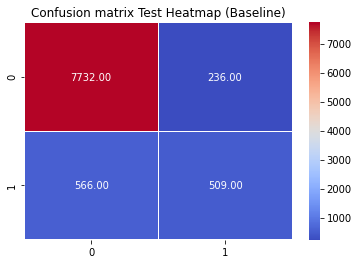

In [ ]:
ax = plt.axes()
sns.heatmap(confusion_matrix(y_test , y_pred), annot=True,  ax=ax, cmap="coolwarm",fmt='.2f', linewidths=.05)
ax.set_title('Confusion matrix Test Heatmap (Baseline)')

# Métodos para manejo de clases desbalanceadas:

- 1 Métodos a nivel de algoritmo: XGB y SVM con pesos
- 2 Métodos a nivel de datos: Over-sampling (SMOTE), Under-sampling (ENN), métodos hibridos (SMOTE+ENN)
- 3 Métodos basados en ensambles: RusBoost

# Algorithm-level Methods:
- XGB Cost-sensitive

In [ ]:
#xgb
def XGBoost_model(num_classes=2):
    
    gbm_param_grid={'learning_rate':[0.3], 
               'n_estimators':[50],
               'subsample':[0.6],
                'colsample_bytree':[0.9],
               'gamma':[0],
               'lambda':[1],
               'scale_pos_weight' : [3,3.3,3.6,3.9,4]
               }
    
    if num_classes ==2:
        gbm=xgb.XGBClassifier(seed=123)
                
    else:
        gbm=xgb.XGBClassifier(objective='multi:softmax',tree_method='gpu_hist', predictor='gpu_predictor')
    
    return gbm, gbm_param_grid 

classifier,params=XGBoost_model()
model = GridSearchCV(classifier,param_grid=params,scoring='roc_auc',cv=5,n_jobs=-1)
model.fit(X_train,y_train)

# Print the tuned parameters and score
print("Tuned XGB Parameters: {}".format(model.best_params_)) 
print("Best score is {}".format(model.best_score_))

Tuned XGB Parameters: {'colsample_bytree': 0.9, 'gamma': 0, 'lambda': 1, 'learning_rate': 0.3, 'n_estimators': 50, 'scale_pos_weight': 3, 'subsample': 0.6}
Best score is 0.9297954976579799


In [ ]:
model=xgb.XGBClassifier(seed=123, learning_rate=0.3,n_estimators=500,subsample=0.6,gamma=0,reg_lambda=1,colsample_bytree=0.9,scale_pos_weight=3)
                    
model.fit(X_train,y_train,eval_set=[(X_test,y_test)],eval_metric='auc',early_stopping_rounds=10)

[0]	validation_0-auc:0.817931
Will train until validation_0-auc hasn't improved in 10 rounds.
[1]	validation_0-auc:0.833835
[2]	validation_0-auc:0.866786
[3]	validation_0-auc:0.869395
[4]	validation_0-auc:0.885235
[5]	validation_0-auc:0.885812
[6]	validation_0-auc:0.888293
[7]	validation_0-auc:0.889872
[8]	validation_0-auc:0.891682
[9]	validation_0-auc:0.898077
[10]	validation_0-auc:0.899878
[11]	validation_0-auc:0.901966
[12]	validation_0-auc:0.90348
[13]	validation_0-auc:0.904797
[14]	validation_0-auc:0.907478
[15]	validation_0-auc:0.90766
[16]	validation_0-auc:0.909285
[17]	validation_0-auc:0.909055
[18]	validation_0-auc:0.910222
[19]	validation_0-auc:0.910811
[20]	validation_0-auc:0.91177
[21]	validation_0-auc:0.911696
[22]	validation_0-auc:0.913383
[23]	validation_0-auc:0.91496
[24]	validation_0-auc:0.915482
[25]	validation_0-auc:0.915914
[26]	validation_0-auc:0.916353
[27]	validation_0-auc:0.916878
[28]	validation_0-auc:0.916909
[29]	validation_0-auc:0.917201
[30]	validation_0-au

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=0.9, gamma=0,
              learning_rate=0.3, max_delta_step=0, max_depth=3,
              min_child_weight=1, missing=None, n_estimators=500, n_jobs=1,
              nthread=None, objective='binary:logistic', random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=3, seed=123,
              silent=None, subsample=0.6, verbosity=1)

In [ ]:
filename = 'XGBCW.sav'
joblib.dump(model, CurrentPath+filename)

['/content/drive/My Drive/Colab Notebooks/PROYECTO/XGBCW.sav']

In [ ]:
model = joblib.load(CurrentPath+'XGBCW.sav')

In [ ]:
#classification_report
y_pred=model.predict(X_test)
y_pred_prob = model.predict_proba(X_test)[:,1] # Compute predicted probabilities: 
ba=balanced_accuracy_score(y_test, y_pred)
print('balanced_accuracy_score: ', round(ba,4))
print()
print(classification_report(y_test, y_pred))

balanced_accuracy_score:  0.8416

              precision    recall  f1-score   support

           0       0.97      0.92      0.94      7968
           1       0.55      0.77      0.64      1075

    accuracy                           0.90      9043
   macro avg       0.76      0.84      0.79      9043
weighted avg       0.92      0.90      0.91      9043



In [ ]:
AUCSxgbCW=round(roc_auc_score(y_test, y_pred_prob),4) # Compute  AUC score
print(AUCSxgbCW)
fprxgbCW, tprxgbCW, thresholdsxgbCW = roc_curve(y_test , y_pred_prob) # Generate ROC curve values: fpr, tpr, thresholds

0.938


Text(0.5, 1.0, 'Confusion matrix Test Heatmap (XGB Class Weights)')

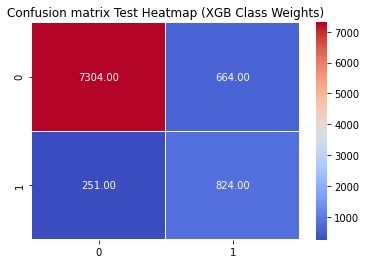

In [ ]:
ax = plt.axes()
sns.heatmap(confusion_matrix(y_test , y_pred), annot=True,  ax=ax, cmap="coolwarm",fmt='.2f', linewidths=.05)
ax.set_title('Confusion matrix Test Heatmap (XGB Class Weights)')

# Características más importantes:



In [ ]:
# Create the DMatrix: 
dmatrix = xgb.DMatrix(data=df2.drop(columns=['y_yes']), label=df2['y_yes'])

# Create the parameter dictionary: params
params = {"objective":"binary:logistic", 'gamma': 0, 'lambda': 1, 'learning_rate': 0.3, 'n_estimators': 60, 'subsample': 0.6,'colsample_bytree':0.9,'scale_pos_weight' :3, 'seed':123}

# Train the model: xg_reg
xg_reg = xgb.train(params=params, dtrain=dmatrix, num_boost_round=60)



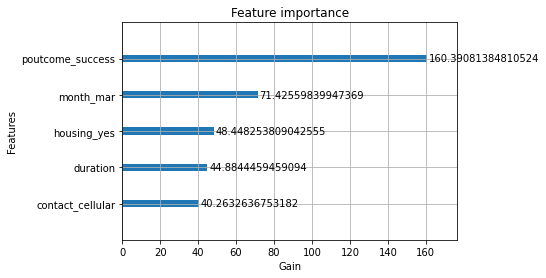

In [ ]:
# Plot the feature importances
xgb.plot_importance(xg_reg,max_num_features=5,importance_type='gain', xlabel='Gain')
plt.show()

# Algorithm-level Methods:
- SVM Cost-sensitive

In [ ]:
#SVM
def SVM_model():
    parameters = [{'C': [ 100,500,1000], 'gamma': [ 0.001],'kernel': ['rbf']}]
        
    return SVC(max_iter=5000,class_weight='balanced',probability=True), parameters

classifier,params=SVM_model()
model = GridSearchCV(classifier,param_grid=params,scoring='roc_auc',cv=5,n_jobs=-1)
model.fit(X_train,y_train)

# Print the tuned parameters and score
print("Tuned SVM Parameters: {}".format(model.best_params_)) 
print("Best score is {}".format(model.best_score_))

Tuned SVM Parameters: {'C': 500, 'gamma': 0.001, 'kernel': 'rbf'}
Best score is 0.718793643968012


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:231: ConvergenceWarning:

Solver terminated early (max_iter=5000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.



In [ ]:
model = SVC(max_iter=-1,class_weight='balanced', C=500,gamma=0.001,kernel='rbf',probability=True)
model.fit(X_train,y_train)

SVC(C=500, break_ties=False, cache_size=200, class_weight='balanced', coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma=0.001, kernel='rbf',
    max_iter=-1, probability=True, random_state=None, shrinking=True, tol=0.001,
    verbose=False)

In [ ]:
filename = 'SMVCW.sav'
joblib.dump(model, CurrentPath+filename)

['/content/drive/My Drive/Colab Notebooks/PROYECTO/DatosModelosCodigo/SMVCW.sav']

In [ ]:
model = joblib.load(CurrentPath+'SMVCW.sav')

In [ ]:
#classification_report
y_pred=model.predict(X_test)
y_pred_prob = model.predict_proba(X_test)[:,1] # Compute predicted probabilities: 
ba=balanced_accuracy_score(y_test, y_pred)
print('balanced_accuracy_score: ', round(ba,4))
print()
print(classification_report(y_test, y_pred))

balanced_accuracy_score:  0.579

              precision    recall  f1-score   support

           0       0.90      0.94      0.92      7968
           1       0.33      0.22      0.26      1075

    accuracy                           0.85      9043
   macro avg       0.61      0.58      0.59      9043
weighted avg       0.83      0.85      0.84      9043



In [ ]:
AUCSSVM=round(roc_auc_score(y_test, y_pred_prob),4) # Compute  AUC score
print(AUCSSVM)
fprSVM, tprSVM, thresholdsSVM = roc_curve(y_test , y_pred_prob) # Generate ROC curve values: fpr, tpr, thresholds

0.7417


Text(0.5, 1.0, 'Confusion matrix Test Heatmap (SVM Class Weights)')

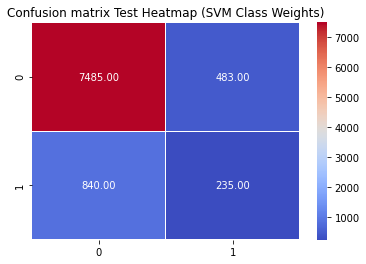

In [ ]:
ax = plt.axes()
sns.heatmap(confusion_matrix(y_test , y_pred), annot=True,  ax=ax, cmap="coolwarm",fmt='.2f', linewidths=.05)
ax.set_title('Confusion matrix Test Heatmap (SVM Class Weights)')

# Data-level Methods:
- Oversampling: SMOTE

https://imbalanced-learn.org/stable/api.html

In [ ]:
#xgb
def XGBoost_model(num_classes=2):
    gbm_param_grid={'xgbclassifier__learning_rate':[0.3], 
               'xgbclassifier__n_estimators':[63,150],
               'xgbclassifier__subsample':[0.6],
                'xgbclassifier__colsample_bytree':[0.9],
               'xgbclassifier__gamma':[0],
               'xgbclassifier__lambda':[1],
               'smote__k_neighbors':range(1, 11) 
               }
    
    if num_classes ==2:
        gbm=xgb.XGBClassifier(seed=123)
                
    else:
        gbm=xgb.XGBClassifier(objective='multi:softmax',tree_method='gpu_hist', predictor='gpu_predictor')
    
    return gbm, gbm_param_grid 

classifier,params=XGBoost_model()
smote=os.SMOTE(random_state=123)
pipeline=imb.pipeline.make_pipeline(smote,classifier)
model = RandomizedSearchCV(pipeline,param_distributions=params,scoring='roc_auc',cv=5,n_jobs=-1,random_state=123)
model.fit(X_train,y_train)

# Print the tuned parameters and score
print("Tuned XGB Parameters: {}".format(model.best_params_)) 
print("Best score is {}".format(model.best_score_))

/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning:

Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.



Tuned XGB Parameters: {'xgbclassifier__subsample': 0.6, 'xgbclassifier__n_estimators': 150, 'xgbclassifier__learning_rate': 0.3, 'xgbclassifier__lambda': 1, 'xgbclassifier__gamma': 0, 'xgbclassifier__colsample_bytree': 0.9, 'smote__k_neighbors': 4}
Best score is 0.9278724802369511


In [ ]:
filename = 'XGBSMOTE.sav'
joblib.dump(model, CurrentPath+filename)

['/content/drive/My Drive/Colab Notebooks/PROYECTO/XGBSMOTE.sav']

In [ ]:
model = joblib.load(CurrentPath+'XGBSMOTE.sav')

In [ ]:
#classification_report
y_pred=model.predict(X_test)
y_pred_prob = model.predict_proba(X_test)[:,1] # Compute predicted probabilities: 
ba=balanced_accuracy_score(y_test, y_pred)
print('balanced_accuracy_score: ', round(ba,4))
print()
print(classification_report(y_test, y_pred))

balanced_accuracy_score:  0.781

              precision    recall  f1-score   support

           0       0.95      0.96      0.95      7968
           1       0.65      0.61      0.63      1075

    accuracy                           0.91      9043
   macro avg       0.80      0.78      0.79      9043
weighted avg       0.91      0.91      0.91      9043



In [ ]:
AUCSxgbSMOTE=round(roc_auc_score(y_test, y_pred_prob),4) # Compute  AUC score
print(AUCSxgbSMOTE)
fprxgbSMOTE, tprxgbSMOTE, thresholdsxgbSMOTE = roc_curve(y_test , y_pred_prob) # Generate ROC curve values: fpr, tpr, thresholds

0.9401


Text(0.5, 1.0, 'Confusion matrix Test Heatmap (XGB SMOTE)')

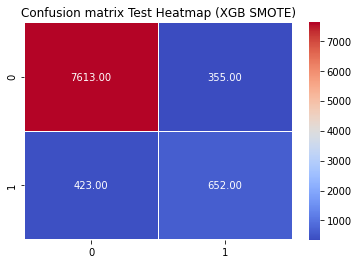

In [ ]:
ax = plt.axes()
sns.heatmap(confusion_matrix(y_test , y_pred), annot=True,  ax=ax, cmap="coolwarm",fmt='.2f', linewidths=.05)
ax.set_title('Confusion matrix Test Heatmap (XGB SMOTE)')

# Data-level Methods:
- Undersampling: ENN

In [ ]:
#xgb
def XGBoost_model(num_classes=2):
    gbm_param_grid={'xgbclassifier__learning_rate':[0.3], 
               'xgbclassifier__n_estimators':[100,150,300],
               'xgbclassifier__subsample':[0.6],
                'xgbclassifier__colsample_bytree':[0.9],
               'xgbclassifier__gamma':[0],
               'xgbclassifier__lambda':[1],
               'editednearestneighbours__n_neighbors':[2,3,4] 
               }
    
    if num_classes ==2:
        gbm=xgb.XGBClassifier(seed=123)
                
    else:
        gbm=xgb.XGBClassifier(objective='multi:softmax',tree_method='gpu_hist', predictor='gpu_predictor')
    
    return gbm, gbm_param_grid 

classifier,params=XGBoost_model()
enn=us.EditedNearestNeighbours(random_state=123,)
pipeline=imb.pipeline.make_pipeline(enn,classifier)
model = RandomizedSearchCV(pipeline,param_distributions=params,scoring='roc_auc',cv=5,n_jobs=-1,random_state=123)
model.fit(X_train,y_train)

# Print the tuned parameters and score
print("Tuned XGB Parameters: {}".format(model.best_params_)) 
print("Best score is {}".format(model.best_score_))

/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_search.py:281: UserWarning:

The total space of parameters 9 is smaller than n_iter=10. Running 9 iterations. For exhaustive searches, use GridSearchCV.

/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning:

Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.

/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning:

Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.



Tuned XGB Parameters: {'xgbclassifier__subsample': 0.6, 'xgbclassifier__n_estimators': 100, 'xgbclassifier__learning_rate': 0.3, 'xgbclassifier__lambda': 1, 'xgbclassifier__gamma': 0, 'xgbclassifier__colsample_bytree': 0.9, 'editednearestneighbours__n_neighbors': 2}
Best score is 0.9292159107780555


In [ ]:
filename = 'XGBSENN.sav'
joblib.dump(model, CurrentPath+filename)

['/content/drive/My Drive/Colab Notebooks/PROYECTO/XGBSENN.sav']

In [ ]:
model = joblib.load(CurrentPath+'XGBSENN.sav')

In [ ]:
#classification_report
y_pred=model.predict(X_test)
y_pred_prob = model.predict_proba(X_test)[:,1] # Compute predicted probabilities: 
ba=balanced_accuracy_score(y_test, y_pred)
print('balanced_accuracy_score: ', round(ba,4))
print()
print(classification_report(y_test, y_pred))

balanced_accuracy_score:  0.814

              precision    recall  f1-score   support

           0       0.96      0.94      0.95      7968
           1       0.59      0.69      0.64      1075

    accuracy                           0.91      9043
   macro avg       0.78      0.81      0.79      9043
weighted avg       0.91      0.91      0.91      9043



In [ ]:
AUCSxgbENN=round(roc_auc_score(y_test, y_pred_prob),4) # Compute  AUC score
print(AUCSxgbENN)
fprxgbENN, tprxgbENN, thresholdsxgbENN = roc_curve(y_test , y_pred_prob) # Generate ROC curve values: fpr, tpr, thresholds

0.9388


Text(0.5, 1.0, 'Confusion matrix Test Heatmap (XGB ENN)')

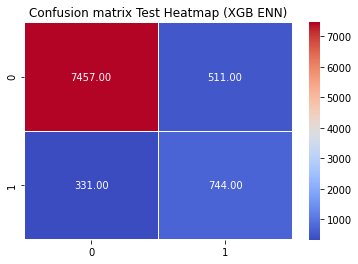

In [ ]:
ax = plt.axes()
sns.heatmap(confusion_matrix(y_test , y_pred), annot=True,  ax=ax, cmap="coolwarm",fmt='.2f', linewidths=.05)
ax.set_title('Confusion matrix Test Heatmap (XGB ENN)')

# Data-level Methods:
- Hybrid methods: SMOTE + ENN

In [ ]:
#xgb
def XGBoost_model(num_classes=2):
    gbm_param_grid={'xgbclassifier__learning_rate':[0.3], 
               'xgbclassifier__n_estimators':[175,200,250],
               'xgbclassifier__subsample':[0.6,0.9,1],
                'xgbclassifier__colsample_bytree':[0.9],
               'xgbclassifier__gamma':[0],
               'xgbclassifier__lambda':[1]
            
               }
    
    if num_classes ==2:
        gbm=xgb.XGBClassifier(seed=123)
                
    else:
        gbm=xgb.XGBClassifier(objective='multi:softmax',tree_method='gpu_hist', predictor='gpu_predictor')
    
    return gbm, gbm_param_grid 

classifier,params=XGBoost_model()
smote=os.SMOTE(random_state=123,k_neighbors=3)
enn=us.EditedNearestNeighbours(random_state=123,n_neighbors=3)
smoteenn=co.SMOTEENN(random_state=123) 
pipeline=imb.pipeline.make_pipeline(smoteenn,classifier)
model = RandomizedSearchCV(pipeline,param_distributions=params,scoring='roc_auc',cv=5,n_jobs=-1,random_state=123)
model.fit(X_train,y_train)

# Print the tuned parameters and score
print("Tuned XGB Parameters: {}".format(model.best_params_)) 
print("Best score is {}".format(model.best_score_))

/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_search.py:281: UserWarning:

The total space of parameters 9 is smaller than n_iter=10. Running 9 iterations. For exhaustive searches, use GridSearchCV.

/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning:

Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.

/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning:

Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.

/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning:

Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.

/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning:

Function safe_indexing is deprecated; safe_indexing is deprecated in v

Tuned XGB Parameters: {'xgbclassifier__subsample': 0.9, 'xgbclassifier__n_estimators': 200, 'xgbclassifier__learning_rate': 0.3, 'xgbclassifier__lambda': 1, 'xgbclassifier__gamma': 0, 'xgbclassifier__colsample_bytree': 0.9}
Best score is 0.9260152387627034


In [ ]:
classifier=xgb.XGBClassifier(seed=123,subsample=0.9,n_estimators=200,learning_rate=0.3,colsample_bytree=0.9)
smoteenn=co.SMOTEENN(random_state=123) 
model=imb.pipeline.make_pipeline(smoteenn,classifier)
model.fit(X_train,y_train)

/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning:

Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.

/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning:

Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.

/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning:

Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.

/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning:

Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.



Pipeline(memory=None,
         steps=[('smoteenn',
                 SMOTEENN(enn=None, random_state=123, ratio=None,
                          sampling_strategy='auto', smote=None)),
                ('xgbclassifier',
                 XGBClassifier(base_score=0.5, booster='gbtree',
                               colsample_bylevel=1, colsample_bynode=1,
                               colsample_bytree=0.9, gamma=0, learning_rate=0.3,
                               max_delta_step=0, max_depth=3,
                               min_child_weight=1, missing=None,
                               n_estimators=200, n_jobs=1, nthread=None,
                               objective='binary:logistic', random_state=0,
                               reg_alpha=0, reg_lambda=1, scale_pos_weight=1,
                               seed=123, silent=None, subsample=0.9,
                               verbosity=1))],
         verbose=False)

In [ ]:
filename = 'XGBSMOTEENN.sav'
joblib.dump(model, CurrentPath+filename)

['/content/drive/My Drive/Colab Notebooks/PROYECTO/XGBSMOTEENN.sav']

In [ ]:
model = joblib.load(CurrentPath+'XGBSMOTEENN.sav')

In [ ]:
#classification_report
y_pred=model.predict(X_test)
y_pred_prob = model.predict_proba(X_test)[:,1] # Compute predicted probabilities: 
ba=balanced_accuracy_score(y_test, y_pred)
print('balanced_accuracy_score: ', round(ba,4))
print()
print(classification_report(y_test, y_pred))

balanced_accuracy_score:  0.8572

              precision    recall  f1-score   support

           0       0.97      0.91      0.94      7968
           1       0.54      0.81      0.65      1075

    accuracy                           0.90      9043
   macro avg       0.76      0.86      0.79      9043
weighted avg       0.92      0.90      0.90      9043



In [ ]:
AUCSxgbSMOTEENN=round(roc_auc_score(y_test, y_pred_prob),4) # Compute  AUC score
print(AUCSxgbSMOTEENN)
fprxgbSMOTEENN, tprxgbSMOTEENN, thresholdsxgbSMOTEENN = roc_curve(y_test , y_pred_prob) # Generate ROC curve values: fpr, tpr, thresholds

0.9373


Text(0.5, 1.0, 'Confusion matrix Test Heatmap (XGB SMOTE+ENN)')

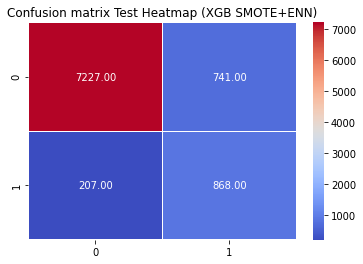

In [ ]:
ax = plt.axes()
sns.heatmap(confusion_matrix(y_test , y_pred), annot=True,  ax=ax, cmap="coolwarm",fmt='.2f', linewidths=.05)
ax.set_title('Confusion matrix Test Heatmap (XGB SMOTE+ENN)')

# Características más importantes:

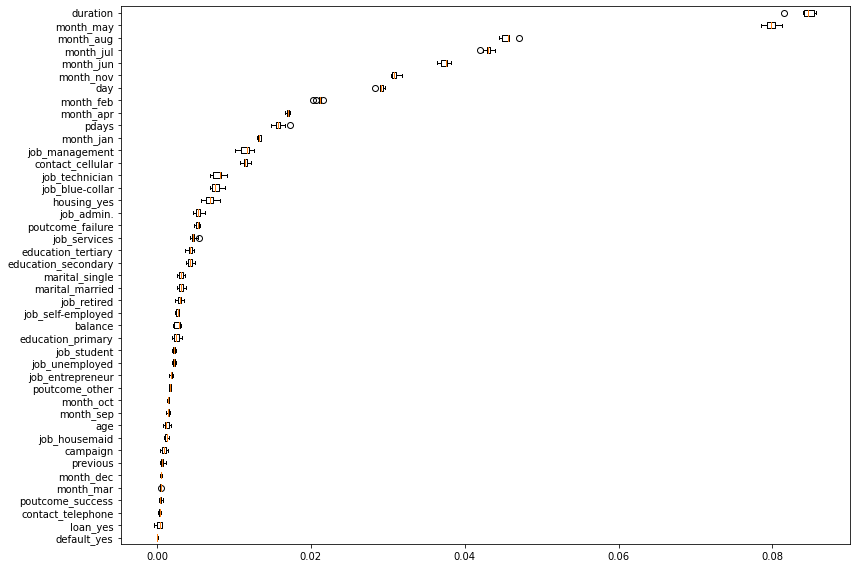

In [ ]:
result = permutation_importance(model, X_train, y_train, n_repeats=10,
                                random_state=42)
perm_sorted_idx = result.importances_mean.argsort()

fig, ax2 = plt.subplots(1, 1, figsize=(12, 8))

ax2.boxplot(result.importances[perm_sorted_idx].T, vert=False,
            labels=df2.columns[perm_sorted_idx])
fig.tight_layout()
plt.show()

# Ensamble-based Methods:
- RUSBoost

In [ ]:

def rusboost_model(num_classes=2):
    rusboost_param_grid={
               'learning_rate':[0.3,0.6], 
               'n_estimators':[100,150,300],
                
            
               }
    
    if num_classes ==2:
      base_estimator = AdaBoostClassifier(n_estimators=10)
      rusboost = ens.RUSBoostClassifier(base_estimator=base_estimator,random_state=123)
        
                
    
        
    
    return rusboost, rusboost_param_grid 

classifier,params=rusboost_model()

model = RandomizedSearchCV(classifier,param_distributions=params,scoring='roc_auc',cv=5,n_jobs=-1,random_state=123)
model.fit(X_train,y_train)

# Print the tuned parameters and score
print("Tuned Parameters: {}".format(model.best_params_)) 
print("Best score is {}".format(model.best_score_))

/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_search.py:281: UserWarning:

The total space of parameters 6 is smaller than n_iter=10. Running 6 iterations. For exhaustive searches, use GridSearchCV.

/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning:

Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.

/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning:

Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.

/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning:

Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.

/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning:

Function safe_indexing is deprecated; safe_indexing is deprecated in v

Tuned XGB Parameters: {'n_estimators': 300, 'learning_rate': 0.3}
Best score is 0.9163280282684838


/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning:

Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.



In [ ]:
base_estimator = AdaBoostClassifier(n_estimators=10)
model = ens.RUSBoostClassifier(base_estimator=base_estimator,random_state=123, learning_rate=0.3,n_estimators=300)
model.fit(X_train,y_train)

/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning:

Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.

/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning:

Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.

/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning:

Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.

/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning:

Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.

/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning:

Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.2

RUSBoostClassifier(algorithm='SAMME.R',
                   base_estimator=AdaBoostClassifier(algorithm='SAMME.R',
                                                     base_estimator=None,
                                                     learning_rate=1.0,
                                                     n_estimators=10,
                                                     random_state=None),
                   learning_rate=0.3, n_estimators=300, random_state=123,
                   replacement=False, sampling_strategy='auto')

In [ ]:
filename = 'RUSBOOST.sav'
joblib.dump(model, CurrentPath+filename)

['/content/drive/My Drive/Colab Notebooks/PROYECTO/RUSBOOST.sav']

In [ ]:
model = joblib.load(CurrentPath+'RUSBOOST.sav')

In [ ]:
#classification_report
y_pred=model.predict(X_test)
y_pred_prob = model.predict_proba(X_test)[:,1] # Compute predicted probabilities: 
ba=balanced_accuracy_score(y_test, y_pred)
print('balanced_accuracy_score: ', round(ba,4))
print()
print(classification_report(y_test, y_pred))

balanced_accuracy_score:  0.8413

              precision    recall  f1-score   support

           0       0.97      0.85      0.91      7968
           1       0.43      0.83      0.56      1075

    accuracy                           0.85      9043
   macro avg       0.70      0.84      0.74      9043
weighted avg       0.91      0.85      0.87      9043



In [ ]:
AUCSxgbrusboost=round(roc_auc_score(y_test, y_pred_prob),4) # Compute  AUC score
print(AUCSxgbrusboost)
fprxgbrusboost, tprxgbrusboost, thresholdsxgbrusboost = roc_curve(y_test , y_pred_prob) # Generate ROC curve values: fpr, tpr, thresholds

0.9176


Text(0.5, 1.0, 'Confusion matrix Test Heatmap (RUSBOOST)')

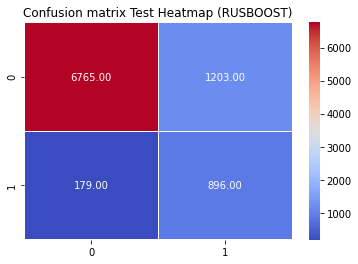

In [ ]:
ax = plt.axes()
sns.heatmap(confusion_matrix(y_test , y_pred), annot=True,  ax=ax, cmap="coolwarm",fmt='.2f', linewidths=.05)
ax.set_title('Confusion matrix Test Heatmap (RUSBOOST)')

# Características más importantes:

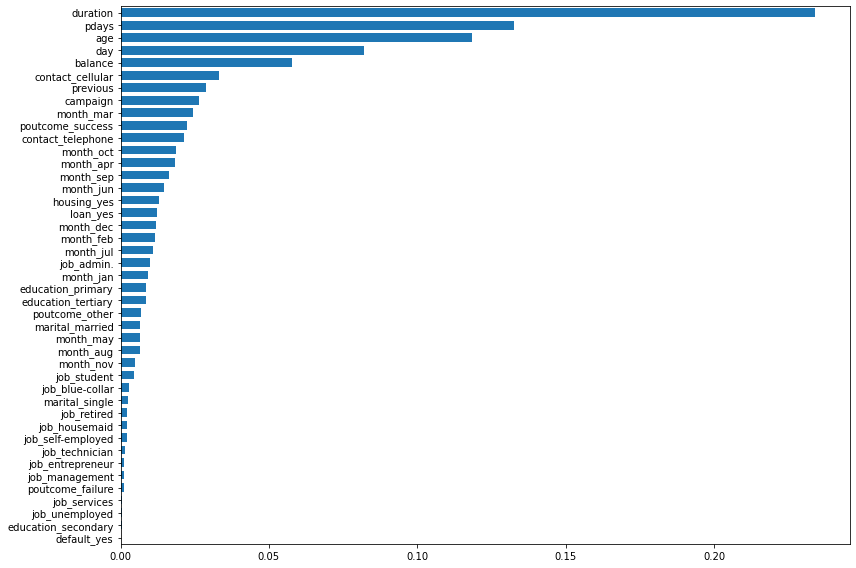

In [ ]:
tree_importance_sorted_idx = np.argsort(model.feature_importances_)
tree_indices = np.arange(0, len(model.feature_importances_)) + 0.5

fig, ax1 = plt.subplots(1, 1, figsize=(12, 8))
ax1.barh(tree_indices,
         model.feature_importances_[tree_importance_sorted_idx], height=0.7)
ax1.set_yticklabels(df2.columns[tree_importance_sorted_idx])
ax1.set_yticks(tree_indices)
ax1.set_ylim((0, len(model.feature_importances_)))

fig.tight_layout()
plt.show()

# Resultados:

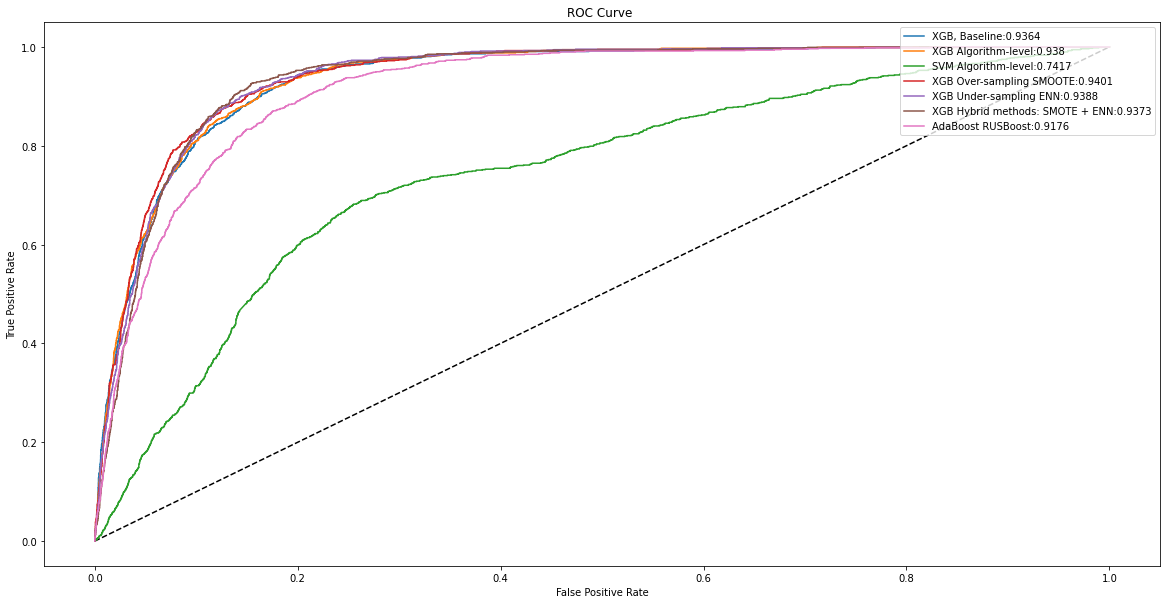

In [ ]:
# # Plot ROC curve
plt.figure(figsize=(20,10))
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fprb, tprb, label='XGB, Baseline:'+str(AUCSb))
plt.plot(fprxgbCW, tprxgbCW, label='XGB Algorithm-level:'+str(AUCSxgbCW))
plt.plot(fprSVM, tprSVM, label='SVM Algorithm-level:'+str(AUCSSVM))
plt.plot(fprxgbSMOTE, tprxgbSMOTE, label='XGB Over-sampling SMOOTE:'+str(AUCSxgbSMOTE))
plt.plot(fprxgbENN, tprxgbENN, label='XGB Under-sampling ENN:'+str(AUCSxgbENN))
plt.plot(fprxgbSMOTEENN, tprxgbSMOTEENN, label='XGB Hybrid methods: SMOTE + ENN:'+str(AUCSxgbSMOTEENN))
plt.plot(fprxgbrusboost, tprxgbrusboost, label='AdaBoost RUSBoost:'+str(AUCSxgbrusboost))
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve ')
plt.legend(loc='upper right')

plt.show()

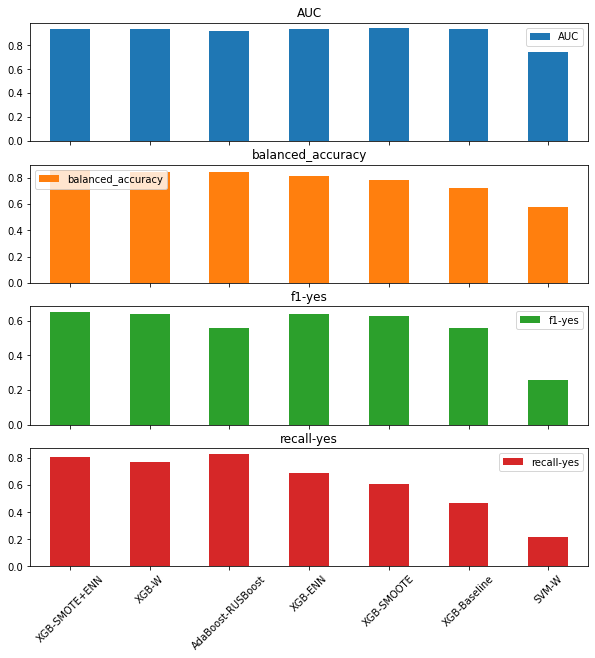

In [ ]:
names=['XGB-Baseline','XGB-W','SVM-W','XGB-SMOOTE','XGB-ENN','XGB-SMOTE+ENN','AdaBoost-RUSBoost' ]
auc=[0.9364,0.938,0.7417,0.9401,0.9388,0.9373,0.9176]
balanced_accuracy=[.721,.841,.579,.781,.814,.857,.841]
f1=[.56,.64,.26,.63,.64,.65,.56]
recall=[.47,.77,.22,.61,.69,.81,.83]


df_mvs_dict={'AUC': auc,
             'balanced_accuracy': balanced_accuracy,
             'f1-yes': f1,
             'recall-yes': recall}

df_mvs=pd.DataFrame(df_mvs_dict)
df_mvs.index=names
df_mvs=df_mvs.sort_values(by='balanced_accuracy', ascending=False)


print()
axes = df_mvs.plot.bar(rot=45, subplots=True,figsize=(10,10))
axes[1].legend(loc=2)  

In [ ]:
df_mvs.describe()

,AUC,balanced_accuracy,f1-yes,recall-yes
count,7.000000,7.000000,7.000000,7.000000
mean,0.907129,0.776286,0.562857,0.628571
std,0.073356,0.098585,0.138890,0.219729
min,0.741700,0.579000,0.260000,0.220000
25%,0.927000,0.751000,0.560000,0.540000
50%,0.937300,0.814000,0.630000,0.690000
75%,0.938400,0.841000,0.640000,0.790000
max,0.940100,0.857000,0.650000,0.830000


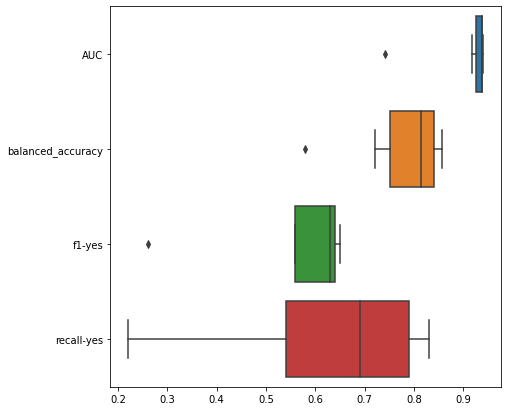

In [ ]:

f, ax = plt.subplots(figsize=(7,7))
sns.boxplot(data=df_mvs,orient="h") #boxplot horizontal